In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import warnings
# !pip install numdifftools
import numdifftools as nd

from scipy.optimize import minimize
from scipy.stats import t as student_t

np.random.seed(42)

# --- I/O settings ---
DATA_FILE = "crsp_data.csv"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.5 MB/s eta 0:00:00


# Question 2

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3541907805.py:30: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel("News impact, $\sigma^2_{t}$")


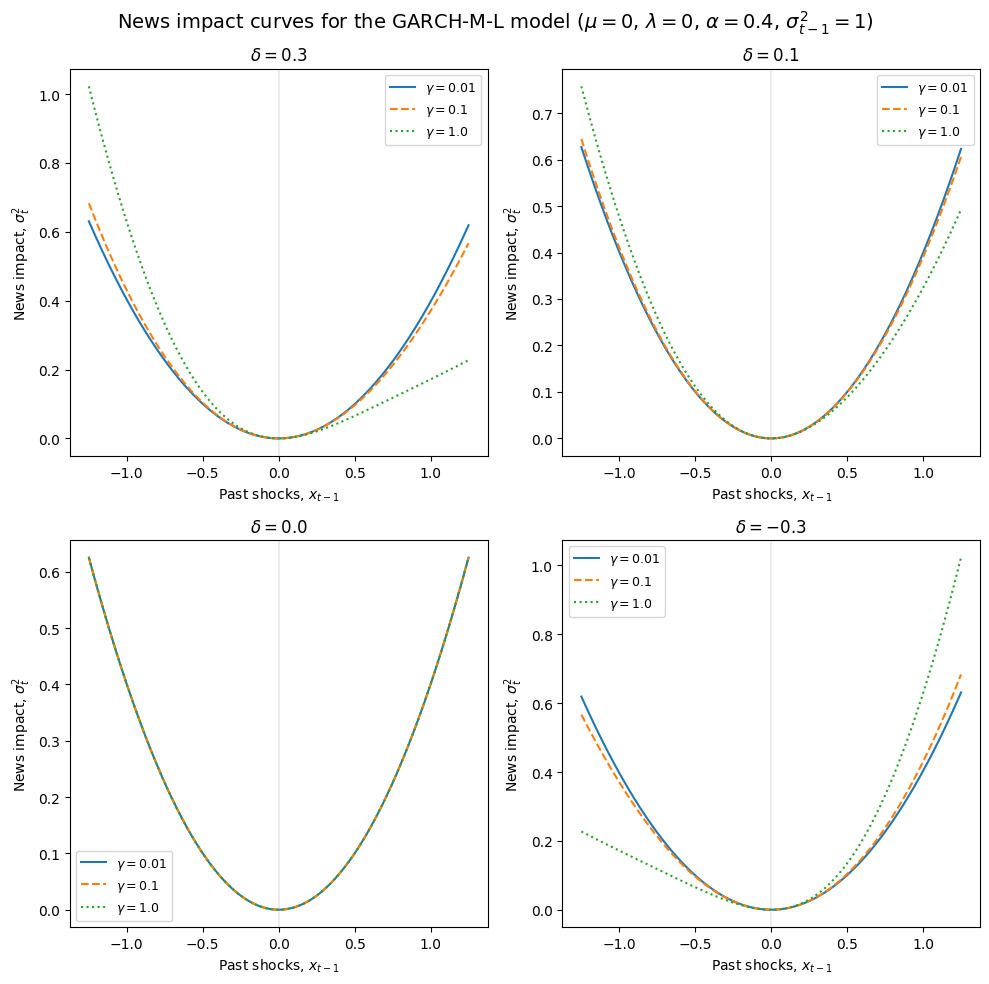

In [3]:
# --- Question 2 ---

# Given parameters and initialization
alpha = 0.4
gamma = [0.01, 0.1, 1.0]
delta = [0.3, 0.1, 0.0, -0.3]

x = np.linspace(-1.25, 1.25,1000) # X-axis
# x = np.linspace(-125, 125,1000) not visible

lines = ['-', '--', ':']

# News Impact Curve definition followed by the given parameter setting as default
def nic(x, delta, gamma, mu = 0, lam = 0, sig2_init = 1, omega = 0, beta = 0):
    NIC = omega + (alpha + delta * np.tanh(-gamma * x)) * ((x-mu-lam*sig2_init)**2/(sig2_init)) + beta * sig2_init
    return NIC

# Ploting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for ax, d in zip(axes, delta):
    for g, style in zip(gamma, lines):
        news_impact = nic(x, d, g)
        ax.plot(x, news_impact, linestyle=style, label=fr"$\gamma={g}$")
    ax.axvline(0, lw=0.3, alpha=0.7, color='grey')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_title(fr"$\delta={d}$")
    ax.set_xlabel(r"Past shocks, $x_{t-1}$")
    ax.set_ylabel("News impact, $\sigma^2_{t}$")
    ax.legend(frameon=True, fontsize=9)

fig.suptitle(r"News impact curves for the GARCH-M-L model $(\mu=0$, $\lambda=0$, $\alpha=0.4$, $\sigma^2_{t-1}=1)$", fontsize=14)
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Q2_NIC_plots.png"), dpi=400, bbox_inches="tight")
fig.savefig(os.path.join(OUT_DIR, "Q2_NIC_plots.pdf"), bbox_inches="tight")

# Question 3

Saved: outputs/Q3_d_stats.csv
Saved: outputs/Q3_d_stats.tex

AAPL check (Mean, Std. Dev., Min, Max):
Mean          0.1071
Std. Dev.     1.7832
Min         -12.8647
Max          11.9808


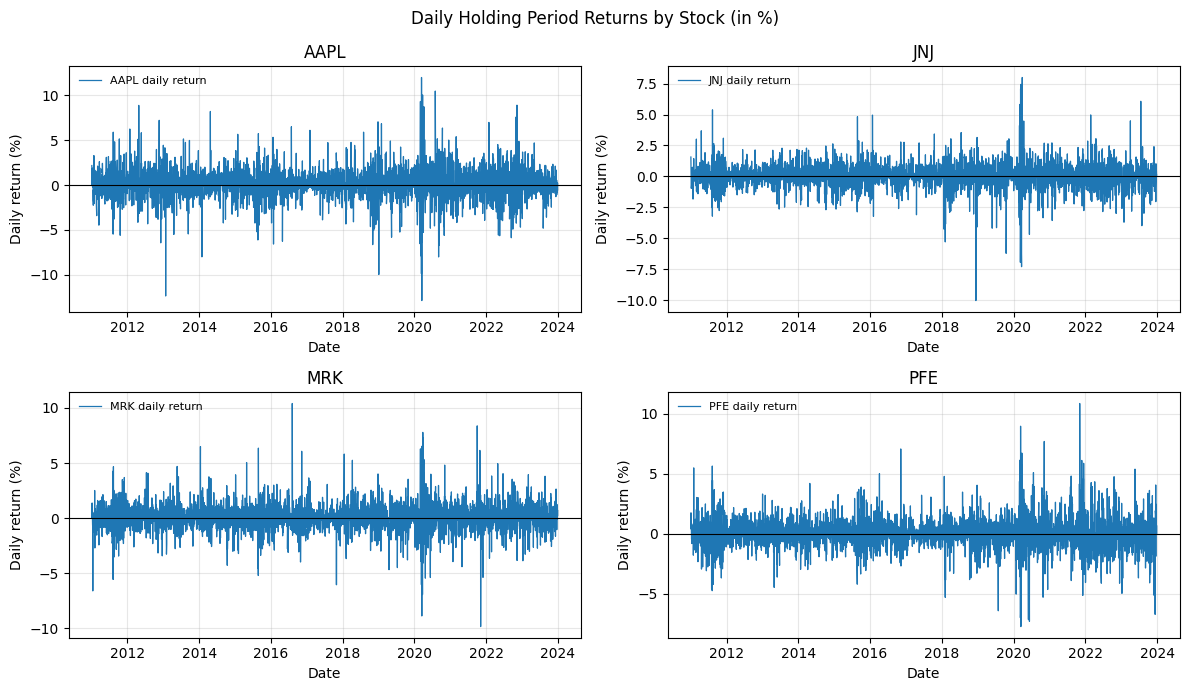

In [6]:
# --- Question 3 ---

# Load data
df = pd.read_csv(DATA_FILE)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Scale returns IN MEMORY (do NOT overwrite CSV on disk)
df["RET"] = df["RET"] * 100

# Descriptive statistics per ticker
def describe_series(x: pd.Series) -> dict:
    x = x.dropna()
    return {
        "N": int(x.shape[0]),
        "Mean": x.mean(),
        "Median": x.median(),
        "Std. Dev.": x.std(ddof=1),
        "Skewness": x.skew(),
        "Excess Kurtosis": x.kurt(),  # pandas: Fisher definition -> excess kurtosis
        "Min": x.min(),
        "Max": x.max(),
    }

stats_rows = []
for tkr, g in df.groupby("TICKER", sort=True):
    stats_rows.append(pd.Series(describe_series(g["RET"]), name=tkr))

stats_df = pd.DataFrame(stats_rows)
stats_df = stats_df[["N","Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]]

# Rounded copy for reporting
stats_rounded = stats_df.copy()
stats_rounded[["Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]] = \
    stats_rounded[["Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]].round(4)

# Save outputs
stats_rounded.to_csv(os.path.join(OUT_DIR, "Q3_d_stats.csv"))
with open(os.path.join(OUT_DIR, "Q3_d_stats.tex"), "w") as f:
    f.write(
        stats_rounded.to_latex(
            caption="Descriptive statistics of daily holding period returns (in %).",
            label="tab:Q3_desc_stats",
            index=True,
            escape=False
        )
    )

print("Saved:", os.path.join(OUT_DIR, "Q3_d_stats.csv"))
print("Saved:", os.path.join(OUT_DIR, "Q3_d_stats.tex"))

# Check Apple values
check = stats_df.loc["AAPL", ["Mean", "Std. Dev.", "Min", "Max"]].round(4)
print("\nAAPL check (Mean, Std. Dev., Min, Max):")
print(check.to_string())


# Plots on 2x2 panel
tickers = ["AAPL", "JNJ", "MRK", "PFE"]
df_plot = df.dropna(subset=["date", "RET"]).copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=False, sharey=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(tickers) and tickers[i] in df_plot["TICKER"].unique():
        tkr = tickers[i]
        sub = df_plot[df_plot["TICKER"] == tkr].sort_values("date")
        ax.plot(sub["date"], sub["RET"], linewidth=0.9, label=f"{tkr} daily return")
        ax.axhline(0, linewidth=0.8, color="black")
        ax.grid(alpha=0.3)
        ax.set_title(tkr)
        ax.set_xlabel("Date")
        ax.set_ylabel("Daily return (%)")
        ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # tick every 2 years
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.legend(loc="upper left", frameon=False, fontsize=8)
    else:
        ax.axis("off")

fig.suptitle("Daily Holding Period Returns by Stock (in %)", y=0.98)

fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Q3_returns_plots.png"), dpi=200, bbox_inches="tight")
fig.savefig(os.path.join(OUT_DIR, "Q3_returns_plots.pdf"), bbox_inches="tight")

In [ ]:
df.head()

# Question 4

In [16]:
# Define negative log-likelihood functions for each GARCH model

def neg_logL_GARCH(params, x):
    mu, omega, alpha, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        resid_prev = (x[t-1] - mu) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-12))
        sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - mu) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL

def neg_logL_GARCH_M(params, x):
    mu, lam, omega, alpha, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        cond_mean = mu + lam * sigma_sqrd[t-1]
        resid_prev = (x[t-1] - cond_mean) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-12))
        sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL

def neg_logL_GARCH_M_L(params, x):
    mu, lam, omega, alpha, delta, gamma, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001 or gamma <= 0:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    if alpha <= abs(delta):
        return 1e10 + 1e8 * (abs(delta) - alpha)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        cond_mean = mu + lam * sigma_sqrd[t-1]
        resid_prev = (x[t-1] - cond_mean) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-6))
        arch_coeff = alpha + delta * np.tanh(-gamma * x[t-1])
        sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL + 0.001 * gamma**2


In [8]:
# Check if log-likelihood is correct w/ givenn optimal parameters

test_params_GARCH = [
    0.154 ,    # mu
    0.038,     # omega
    0.090,     # alpha
    0.873,     # beta
    4.146      # nu
]

test_params_GARCH_M = [
    0.072,     # mu
    0.061,     # lam
    0.037,     # omega
    0.089,     # alpha
    0.875,     # beta
    4.138      # nu
]

test_params_GARCH_M_L = [
    0.108,     # mu
    0.022,     # lam
    0.012,     # omega
    0.073,     # alpha
    0.071,     # delta
    0.439,     # gamma
    0.915,     # beta
    4.402      # nu
]

# Get your data
ret_AAPL = df[df['TICKER'] == 'AAPL']['RET'].iloc[:2500]

# Calculate the negative log-likelihood for each parameter set
nll_garch = neg_logL_GARCH(test_params_GARCH, ret_AAPL)
nll_garch_m = neg_logL_GARCH_M(test_params_GARCH_M, ret_AAPL)
nll_garch_m_l = neg_logL_GARCH_M_L(test_params_GARCH_M_L, ret_AAPL)

# Print the results
print(f"Log-Likelihood for GARCH: {-nll_garch:.0f}") # Should be -4662
print("---")
print(f"Log-Likelihood for GARCH-M: {-nll_garch_m:.0f}") # Should be -4662
print("---")
print(f"Log-Likelihood for GARCH-M-L: {-nll_garch_m_l:.0f}")

Log-Likelihood for GARCH: -4662
---
Log-Likelihood for GARCH-M: -4662
---
Log-Likelihood for GARCH-M-L: -4632


In [48]:
# Define functions to fit each GARCH model

def fit_GARCH_model(returns, model_type, start_params, bounds):
    x = np.asarray(returns, dtype=float)
    T = x.size

    if model_type == 'GARCH':
        obj_func = neg_logL_GARCH
    elif model_type == 'GARCH-M':
        obj_func = neg_logL_GARCH_M
    elif model_type == 'GARCH-M-L':
        obj_func = neg_logL_GARCH_M_L
    else:
        raise ValueError("Invalid model type specified.")

    optim = minimize(lambda p: obj_func(p, x),
                     x0=start_params,
                     bounds=bounds,
                     method='L-BFGS-B',
                     options={'disp': False})

    param_estimates = optim.x
    H, cov, se = None, None, None
    if nd:
        try:
            hess_func = nd.Hessian(lambda p: obj_func(p, x))
            H = hess_func(param_estimates)
            cov = np.linalg.pinv(H)
            se = np.sqrt(np.maximum(np.diag(cov), 0.0))
        except Exception as e:
            warnings.warn(f"Hessian failed: {e}")

    # Re-calculate final sigma and standardized residuals using the estimated params
    final_params = param_estimates
    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x - np.average(x[:50]))**2)

    # Note: This block re-simulates the variance.
    if model_type == 'GARCH':
        mu, omega, alpha, beta, nu = final_params
        cond_mean = mu
        for t in range(1, T):
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - cond_mean) / np.sqrt(sigma_sqrd)
    elif model_type == 'GARCH-M':
        mu, lam, omega, alpha, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)
    elif model_type == 'GARCH-M-L':
        mu, lam, omega, alpha, delta, gamma, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            arch_coeff = alpha + delta * np.tanh(-gamma * x[t-1])
            sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)
    else:
        raise ValueError("Invalid model type specified.")

    logL = -optim.fun
    k = len(param_estimates)

    result = {
        'params': param_estimates,
        'se': se,
        'cov': cov,
        'hess': H,
        'nll': optim.fun,
        'success': optim.success,
        'message': optim.message,
        'fitted_sigma2': sigma_sqrd,
        'std_resid': epsilon,
        'df': T,
        'logL': logL,
        'AIC': 2*k - 2*logL,
        'BIC': k*np.log(T) - 2*logL
    }
    return result

In [18]:
def print_results(results_dict, model_type):

    print("="*60)
    print(f"RESULTS FOR THE {model_type.upper()} MODEL")
    print("="*60)

    # Check if the optimization was successful
    if not results_dict['success']:
        print(f"Warning: Optimization failed. Message: {results_dict['message']}\n")

    # Define parameter names based on the model type
    if model_type == 'GARCH':
        param_names = ['mu', 'omega', 'alpha', 'beta', 'nu']
    elif model_type == 'GARCH-M':
        param_names = ['mu', 'lam', 'omega', 'alpha', 'beta', 'nu']
    elif model_type == 'GARCH-M-L':
        param_names = ['mu', 'lam', 'omega', 'alpha', 'delta', 'gamma', 'beta', 'nu']
    else:
        param_names = [] # Fallback for unknown model types

    # Create a table for parameters and standard errors
    params = results_dict['params']
    se = results_dict['se']

    if se is not None and len(se) == len(params):
        param_table = pd.DataFrame({
            'Parameter': results_dict['params'],
            'Standard Error': results_dict['se']
        })
        param_table.index = param_names
        print("\n-------Parameter  Estimates-------")
        print(param_table.to_string(float_format="%.3f"))

    else:
        print("\n-------Parameter  Estimates-------")
        for name, value in zip(param_names, params):
            print(f"  {name: <10}: {value: .3f}")

    print("\n------Goodness of Fit Metrics------")
    print(f"  Negative Log-Likelihood: {results_dict['nll']:.3f}")
    print(f"  Log-Likelihood: {results_dict['logL']:.3f}")
    print(f"  AIC (Akaike Information Criterion): {results_dict['AIC']:.3f}")
    print(f"  BIC (Bayesian Information Criterion): {results_dict['BIC']:.3f}")

    print("="*60)

In [50]:
# Define bounds for each model
bounds_GARCH = [
    (-2.0, 2.0),     # mu
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

bounds_GARCH_M = [
    (-2.0, 2.0),     # mu
    (-0.2, 0.2),     # lambda
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

bounds_GARCH_M_L = [
    (-2.0, 2.0),     # mu
    (-0.2, 0.2),     # lambda  (first pass)
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (-1.0, 1.0),     # delta
    (1e-6, 20.0),    # gamma   (20 already saturates over |x|<=5)
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

In [54]:
# Lists of tickers, model types, start parameters, and bounds

tickers_to_fit = ['PFE', 'JNJ', 'MRK', 'AAPL']
model_types = ['GARCH', 'GARCH-M', 'GARCH-M-L']
bounds_list = [bounds_GARCH, bounds_GARCH_M, bounds_GARCH_M_L]

results = {}

# Loop over tickers and model type

for ticker in tickers_to_fit:
  print("=" * 60)
  print(f"\nFITTING MODELS FOR TICKER: {ticker}\n")
  print("=" * 60)

  ret_per_ticker = df[df['TICKER'] == ticker]['RET'].iloc[:2500]
  sample_var = np.var(ret_per_ticker)

  start_param_GARCH = [
      0,                 # mu
      sample_var / 50,   # omega
      0.05,              # alpha
      0.9,               # beta
      10                 # nu
  ]

  start_param_GARCH_M = [
      0,                 # mu
      0,                 # lambda
      sample_var / 50,   # omega
      0.05,              # alpha
      0.9,               # beta
      10                 # nu
  ]

  start_param_GARCH_M_L = [
      0,                 # mu
      0,                 # lambda
      sample_var / 50,   # omega
      0.05,              # alpha
      0.01,              # delta
      0.01,              # gamma
      0.9,               # beta
      10                 # nu
  ]

  model_fit_list = []
  start_params_list = [start_param_GARCH, start_param_GARCH_M, start_param_GARCH_M_L]

  for model_type, start_params, bounds in zip(model_types, start_params_list, bounds_list):
      results = fit_GARCH_model(ret_per_ticker, model_type, start_params, bounds)
      model_fit_list.append(results)
      print_results(results, model_type)

  results[ticker] = model_fit_list


FITTING MODELS FOR TICKER: PFE



/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:18: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.059           0.019
omega      0.000           0.000
alpha      0.043           0.008
beta       0.915           0.010
nu         4.659           0.448

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3773.495
  Log-Likelihood: -3773.495
  AIC (Akaike Information Criterion): 7556.990
  BIC (Bayesian Information Criterion): 7586.110


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:49: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.019           0.044
lam        0.060           0.060
omega      0.000           0.000
alpha      0.042           0.008
beta       0.917           0.010
nu         4.662           0.448

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3773.001
  Log-Likelihood: -3773.001
  AIC (Akaike Information Criterion): 7558.001
  BIC (Bayesian Information Criterion): 7592.945


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:85: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M-L MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu        -0.045           0.037
lam        0.122           0.051
omega      0.000           0.000
alpha      0.044           0.000
delta      0.027           0.000
gamma     17.124          21.764
beta       0.920           0.000
nu         4.903           0.448

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3759.098
  Log-Likelihood: -3759.098
  AIC (Akaike Information Criterion): 7534.196
  BIC (Bayesian Information Criterion): 7580.788

FITTING MODELS FOR TICKER: JNJ



/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:18: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.067           0.016
omega      0.002           0.000
alpha      0.054           0.000
beta       0.904           0.000
nu         9.941           0.000

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3311.187
  Log-Likelihood: -3311.187
  AIC (Akaike Information Criterion): 6632.375
  BIC (Bayesian Information Criterion): 6661.495


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:49: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.058           0.035
lam        0.032           0.070
omega      0.000           0.000
alpha      0.025           0.000
beta       0.919           0.000
nu         4.387           0.290

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3282.819
  Log-Likelihood: -3282.819
  AIC (Akaike Information Criterion): 6577.639
  BIC (Bayesian Information Criterion): 6612.583


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:85: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M-L MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.033           0.029
lam        0.063           0.057
omega      0.003           0.000
alpha      0.026           0.000
delta      0.017           0.000
gamma      1.229           0.678
beta       0.916           0.000
nu         4.557           0.122

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3270.353
  Log-Likelihood: -3270.353
  AIC (Akaike Information Criterion): 6556.707
  BIC (Bayesian Information Criterion): 6603.299

FITTING MODELS FOR TICKER: MRK



/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:18: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.078           0.020
omega      0.078           0.000
alpha      0.043           0.000
beta       0.832           0.000
nu         4.763           0.436

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3899.053
  Log-Likelihood: -3899.053
  AIC (Akaike Information Criterion): 7808.106
  BIC (Bayesian Information Criterion): 7837.227


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:49: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.077           0.050
lam       -0.015           0.060
omega      0.015           0.000
alpha      0.040           0.009
beta       0.904           0.013
nu         4.502           0.402

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3892.892
  Log-Likelihood: -3892.892
  AIC (Akaike Information Criterion): 7797.783
  BIC (Bayesian Information Criterion): 7832.728


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:85: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M-L MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.094           0.032
lam        0.065           0.027
omega      0.044           0.000
alpha      0.076           0.000
delta      0.076           0.000
gamma      0.121           0.030
beta       0.867           0.008
nu         9.977           0.000

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 3912.228
  Log-Likelihood: -3912.228
  AIC (Akaike Information Criterion): 7840.456
  BIC (Bayesian Information Criterion): 7887.048

FITTING MODELS FOR TICKER: AAPL



/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:18: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.154           0.027
omega      0.038           0.027
alpha      0.090           0.022
beta       0.874           0.032
nu         4.146           0.360

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 4662.483
  Log-Likelihood: -4662.483
  AIC (Akaike Information Criterion): 9334.965
  BIC (Bayesian Information Criterion): 9364.086


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:49: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:51: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.072           0.067
lam        0.061           0.045
omega      0.037           0.027
alpha      0.089           0.022
beta       0.875           0.032
nu         4.138           0.359

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 4661.551
  Log-Likelihood: -4661.551
  AIC (Akaike Information Criterion): 9335.103
  BIC (Bayesian Information Criterion): 9370.047


/tmp/ipython-input-3403282965.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optim = minimize(lambda p: obj_func(p, x),
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar multiply
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar power
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:88: RuntimeWarning: overflow encountered in scalar add
  sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
/tmp/ipython-input-819703170.py:85: RuntimeWarning: overflow encountered in scalar multiply
  cond_mean = mu + lam * sigma_sqrd[t-1]


RESULTS FOR THE GARCH-M-L MODEL

-------Parameter  Estimates-------
       Parameter  Standard Error
mu         0.096           0.060
lam        0.027           0.040
omega      0.023           0.008
alpha      0.069           0.011
delta      0.061           0.000
gamma     10.474          22.075
beta       0.911           0.012
nu         4.400           0.369

------Goodness of Fit Metrics------
  Negative Log-Likelihood: 4633.076
  Log-Likelihood: -4633.076
  AIC (Akaike Information Criterion): 9282.152
  BIC (Bayesian Information Criterion): 9328.745
